### Imports

In [1]:
import os
import json
import string
import itertools
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from sdv.metadata import Metadata
from sdv.sequential import PARSynthesizer

from simulation.simulation_tools import get_optimal_sim_XY, run_detection_metrics, run_detection_metrics_XY, prepare_det_data
from simulation.simulation_metrics import mmd_torch

import sys
import warnings
import numpy as np
import pandas as pd

from CausalTime.tools import generate_CT

from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import TimeSeriesDataLoader
warnings.filterwarnings("ignore")

COL_NAMES = list(string.ascii_uppercase) + ["".join(a) for a in list(itertools.permutations(list(string.ascii_uppercase), r=2))]

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Data & Comparison

In [ ]:
par_dir = Path(os.getcwd()).parents[1].as_posix() 
FN = "AirQualityUCI"

# Data structure as such for convenient comparison with CausalTime
DATA_DICT = {
    # # NOTE: uncomment for MvTS real data
    filename.split(".csv")[0]: {
        'data_path': f"{par_dir}/data/MvTS/{FN}/",
        'data_type': 'fmri',
        'task': filename, 
        'straight_path': f"{par_dir}/data/MvTS/{FN}/" + f"{filename}"
    } for filename in os.listdir(f"{par_dir}/data/MvTS/{FN}/")

    # # NOTE: uncomment for the rest data
    # filename.split(".csv")[0]: {
    #     'data_path': f"{par_dir}/data/{FN}/",
    #     'data_type': 'fmri',
    #     'task': filename, 
    #     'straight_path': f"{par_dir}/data/{FN}/" + f"{filename}"
    # } for filename in os.listdir(f"{par_dir}/data/{FN}/")
}

# CausalTime Parameters
PARAMS = {
    "batch_size" : 32, 
    "hidden_size" : 128, 
    "num_layers" : 2, 
    "dropout" : 0.1, 
    "seq_length" : 20, 
    "test_size" : 0.2, 
    "learning_rate" : 0.0001, 
    "n_epochs" : 1, 
    "flow_length" : 4, 
    "gen_n" : 20, 
    "n" : 2000,
    "arch_type" : "MLP", 
    "save_path" : "outputs/", 
    "log_dir" : "log/", 
}

# Placeholders
det_dict = {}
auc_dict_tcs = {}
data_dict_tcs = {}
auc_dict_ct = {}
data_dict_ct = {}
auc_dict_sdv = {}
data_dict_sdv = {}
auc_dict_tvae = {}
data_dict_tvae = {}

mmd_dict_tcs = {}
mmd_dict_ct = {}
mmd_dict_sdv = {}
mmd_dict_tvae = {}

for k, v in list(DATA_DICT.items())[:]:

    try:
    
        # info
        filename = v['task']
        print(f" \n------------- {filename} ---------------\n ")

        # data
        true_data = pd.read_csv(v["straight_path"])
        true_data = true_data.rename(columns=dict(zip(true_data.columns, COL_NAMES[:true_data.shape[1]])))
        
        # adjust timesteps for computation time (1000 max)
        print(f"true data length: {true_data.shape[0]}")

        if true_data.shape[0]>2000:
            anchor = np.random.uniform(low=0, high=true_data.shape[0]-2000)
            true_data = true_data.loc[anchor : anchor + 2000, :]
            print(f"true data length (adjusted): {true_data.shape[0]}")

        for i in range(true_data.shape[0]):
            for j in range(true_data.shape[1]):
                if true_data.iloc[i, j] == 0:
                    true_data.iloc[i, j] += np.random.uniform(low=0.0001, high=0.001)
        

        """ ____________________________________ Simulate w/ TCS ____________________________________ """

        results_tcs = get_optimal_sim_XY(true_data=true_data)
        tcs_data = results_tcs["optimal_data"]
        tcs_auc = results_tcs["auc"]

        """ Get optimal det & config """
        optimal_det_config = results_tcs["optimal_detector_config"]
        optimal_det_func = results_tcs["optimal_detector"]

        # Fix potential length mismatches
        if true_data.shape[0] > tcs_data.shape[0]:
            true_data = true_data[:tcs_data.shape[0]]
        elif true_data.shape[0] < tcs_data.shape[0]:
            tcs_data = tcs_data[:true_data.shape[0]]

        # Evaluate
        print(f"LOG : true shape - {true_data.shape} VS tcs shape - {tcs_data.shape}")
        train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=tcs_data)
        tcs_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']

        mmd = mmd_torch(synthetic=tcs_data, real=true_data)

        # Store
        mmd_dict_tcs[filename] = mmd
        auc_dict_tcs[filename] = tcs_auc
        data_dict_tcs[filename] = tcs_data.copy()


        print("""\n ____________________________________ Simulate w/ CausalTime ____________________________________ \n""")

        true_pd, pro_true_pd, skimmed_pd, pro_gen_pd = generate_CT(
                batch_size=PARAMS["batch_size"], 
                hidden_size=PARAMS["hidden_size"], 
                num_layers=PARAMS["num_layers"], 
                dropout=PARAMS["dropout"], 
                seq_length=PARAMS["seq_length"], 
                test_size=PARAMS["test_size"], 
                learning_rate=PARAMS["learning_rate"], 
                n_epochs=PARAMS["n_epochs"], 
                flow_length=PARAMS["flow_length"], 
                gen_n=PARAMS["gen_n"], 
                n=PARAMS["n"],
                arch_type=PARAMS["arch_type"], 
                save_path=PARAMS["save_path"], 
                log_dir=PARAMS["log_dir"], 
                data_path=v["data_path"],
                data_type= v["data_type"], 
                task= v["task"],
            )
        ct_data = pro_gen_pd.copy()

        # Fix potential length mismatches
        if true_data.shape[0] > ct_data.shape[0]:
            true_data = true_data[:ct_data.shape[0]]
        elif true_data.shape[0] < ct_data.shape[0]:
            ct_data = ct_data[:true_data.shape[0]]

        # Evaluate
        print(f"LOG : true shape - {true_data.shape} VS ct shape - {ct_data.shape}")
        train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=ct_data)
        ct_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']

        mmd = mmd_torch(synthetic=ct_data, real=true_data)

        # Store
        mmd_dict_ct[filename] = mmd
        auc_dict_ct[filename] = ct_auc
        data_dict_ct[filename] = ct_data.copy()


        print("""\n ____________ Simulate w/ SDV ____________ \n""")

        true_data_sdv = true_data.copy()

        # Creating same conditions as CausalTime
        els = true_data_sdv.shape[0] % (true_data_sdv.shape[0]//20)
        if els!=0:
            true_data_sdv = true_data_sdv.iloc[:-els, :]

        # Sequence key
        true_data_sdv.loc[:, 'id'] = [i for i in range(true_data_sdv.shape[0]//20) for _ in range(20)]

        # Metadata
        metadata = Metadata.detect_from_dataframe(data=true_data_sdv)
        metadata.tables["table"].columns["id"]["sdtype"] = "id"
        metadata.set_sequence_key(column_name='id')

        # Synthesizer
        synthesizer = PARSynthesizer(metadata)
        synthesizer.fit(data=true_data_sdv)
        synthetic_data = synthesizer.sample(num_sequences=true_data_sdv.shape[0]//20 + 1)

        # Fix potential length mismatches
        sdv_data = synthetic_data.loc[:len(true_data), :].drop(columns=["id"])
        if true_data.shape[0] > sdv_data.shape[0]:
            true_data = true_data[:sdv_data.shape[0]]
        elif true_data.shape[0] < sdv_data.shape[0]:
            sdv_data = sdv_data[:true_data.shape[0]]
        
        mmd = mmd_torch(synthetic=sdv_data, real=true_data)

        # Evaluate
        print(f"LOG : true shape - {true_data.shape} VS sdv shape - {sdv_data.shape}")
        train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=sdv_data)
        sdv_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']

        # Store
        mmd_dict_sdv[filename] = mmd
        auc_dict_sdv[filename] = sdv_auc
        data_dict_sdv[filename] = sdv_data.copy()


        print("""\n _____________ Simulate w/ TimeVAE _____________ \n""")
        
        # Prepare TimeVAE Data
        dat = true_data.copy()

        n_samples = dat.shape[0]
        if 'target' in dat.columns:
            X = dat.drop(columns=['target']) 
            y = dat['target'] 
        else:
            X = dat
            y = None

        temporal_data = [X]
        observation_times = [X.index.to_numpy()]

        # Initialize the TimeSeriesDataLoader
        X_loader = TimeSeriesDataLoader(
            temporal_data=temporal_data, 
            observation_times=observation_times, 
            outcome=y,
            static_data=None,
            train_size=1.0, 
            test_size=0.0
        )

        # Define plugin kwargs for TimeVAE
        plugin_kwargs = dict(
            n_iter=30,
            batch_size=64,
            lr=0.001,
            encoder_n_layers_hidden=2,
            decoder_n_layers_hidden=2,
            encoder_dropout=0.05,
            decoder_dropout=0.05
        )

        # Initialize the generative model for TimeVAE
        test_plugin = Plugins().get("tvae", **plugin_kwargs)
        # test_plugin = Plugins().get("timegan", ?)

        # Fit the model
        if y is not None:
            test_plugin.fit(X_loader, cond=y)
        else:
            test_plugin.fit(X_loader)

        # Generate synthetic data
        generated_data = test_plugin.generate(count=n_samples) 

        # Extract the generated time-series data
        generated_data = generated_data.data["seq_data"]

        # Drop unnecessary columns like "seq_id", "seq_time_id"
        generated_data = generated_data.drop(columns=["seq_id", "seq_time_id"])

        # Fix potential length mismatches
        if true_data.shape[0] > generated_data.shape[0]:
            true_data = true_data[:generated_data.shape[0]]
        elif true_data.shape[0] < generated_data.shape[0]:
            generated_data = generated_data[:true_data.shape[0]]

        # Evaluate TimeVAE generated data
        print(f"LOG : true shape - {true_data.shape} VS generated shape - {generated_data.shape}")
        train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=generated_data)
        tvae_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']

        mmd = mmd_torch(synthetic=generated_data, real=dat)

        # Store results for TimeVAE
        mmd_dict_tvae[filename] = mmd
        auc_dict_tvae[filename] = tvae_auc
        data_dict_tvae[filename] = generated_data.copy()
    
    except:
        continue

In [ ]:
print(f"TCS Mean AUC: {np.array(list(auc_dict_tcs.values())).mean()}")
print(f"TCS Var AUC: {np.array(list(auc_dict_tcs.values())).var()}")

print(f"TCS Mean MMD: {np.array(list(mmd_dict_tcs.values())).mean()}")
print(f"TCS Var MMD: {np.array(list(mmd_dict_tcs.values())).var()}")

print(f"CT Mean AUC: {np.array(list(auc_dict_ct.values())).mean()}")
print(f"CT Var AUC: {np.array(list(auc_dict_ct.values())).var()}")

print(f"CT Mean MMD: {np.array(list(mmd_dict_ct.values())).mean()}")
print(f"CT Var MMD: {np.array(list(mmd_dict_ct.values())).var()}")

print(f"CPAR Mean AUC: {np.array(list(auc_dict_sdv.values())).mean()}")
print(f"CPAR Var AUC: {np.array(list(auc_dict_sdv.values())).var()}")

print(f"CPAR Mean MMD: {np.array(list(mmd_dict_sdv.values())).mean()}")
print(f"CPAR Var MMD: {np.array(list(mmd_dict_sdv.values())).var()}")

print(f"TimeVAE Mean AUC: {np.array(list(auc_dict_tvae.values())).mean()}")
print(f"TimeVAE Var AUC: {np.array(list(auc_dict_tvae.values())).var()}")

print(f"TimeVAE Mean MMD: {np.array(list(mmd_dict_tvae.values())).mean()}")
print(f"TimeVAE Var MMD: {np.array(list(mmd_dict_tvae.values())).var()}")

### Store and visualize results

In [ ]:
# Reformat
save_path = Path(os.getcwd()).parents[1] / "data" / "results" / "vs"

auc_dict_tcs
auc_dict = {}
mmd_dict = {}

for k in list(auc_dict_tcs.keys())[:]:
    auc_dict[k] = {
        "tcs" : auc_dict_tcs[k], 
        "ct" : auc_dict_ct[k],
        "cpar" : auc_dict_sdv[k],
        "tvae" : auc_dict_tvae[k],
    }

for k in list(mmd_dict_tcs.keys())[:]:
    mmd_dict[k] = {
        "tcs" : mmd_dict_tcs[k], 
        "ct" : mmd_dict_ct[k],
        "cpar" : mmd_dict_sdv[k],
        "tvae" : mmd_dict_tvae[k],
    }


# Store as JSON 
json.dump(auc_dict, open(save_path / f"{FN}_auc.json", "w"))
json.dump(mmd_dict, open(save_path / f"{FN}_mmd.json", "w"))

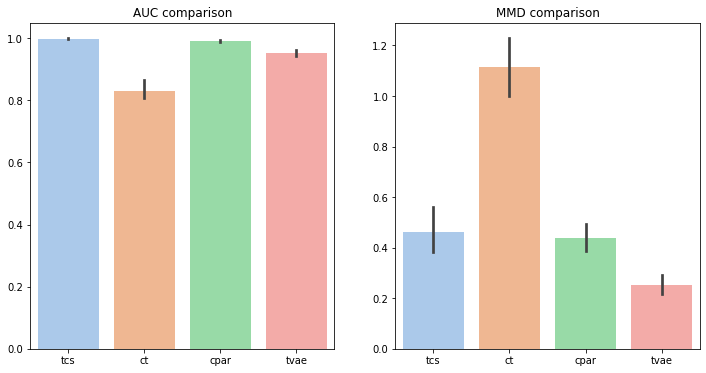

In [ ]:
# Load JSON
save_path = Path(os.getcwd()).parents[1] / "data" / "results" / "vs"

auc_dict = json.load(open(save_path / f"{FN}_auc.json", "r"))
mmd_dict = json.load(open(save_path / f"{FN}_mmd.json", "r"))
auc_df = pd.DataFrame(auc_dict).T
mmd_df = pd.DataFrame(mmd_dict).T

# Plot
f, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.barplot(data=auc_df, palette="pastel", ax=axs[0])
axs[0].set_title("AUC comparison")
sns.barplot(data=mmd_df, palette="pastel", ax=axs[1])
axs[1].set_title("MMD comparison")
plt.show()

### Notes

#### Helping code to create block-bootstraped versions of a large dataset 

In [ ]:
# # Parameters
# SET_LEN = 2000
# FN = "AirQualityUCI"

# # Path
# par_dir = Path(os.getcwd()).parents[1].as_posix() 
# target_path = f"{par_dir}/data/MvTS/{FN}"

# # Data
# original = pd.read_csv(target_path + f'/{FN}_original.csv')
# original = original.rename(columns=dict(zip(
#     original.columns, 
#     COL_NAMES
# )))

# # adjust timesteps for computation time (1500 max)
# print(f"true data length: {original.shape[0]}")
# if original.shape[0]>SET_LEN:
#     for b in range(20):
#         anchor = np.random.uniform(low=0, high=original.shape[0] - SET_LEN)
#         boot = original.loc[anchor : anchor + SET_LEN, :]
#         print(f"true data length (adjusted): {boot.shape[0]}")
#         boot.to_csv(target_path + f"/{FN}_boot_{b}.csv", index=False)